## Домашнее задание

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


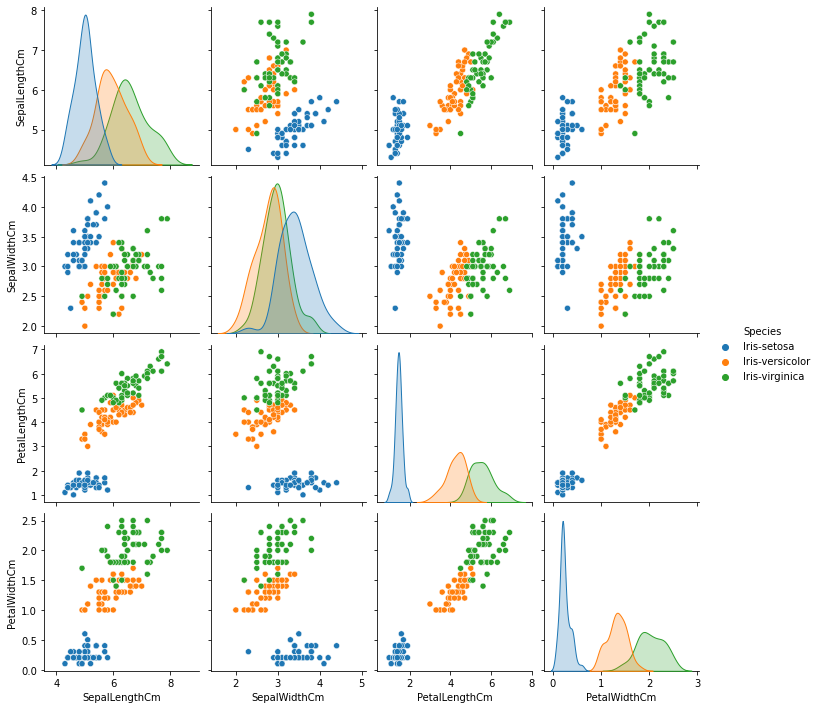

In [3]:

### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("../data/Iris.csv")
print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [4]:
def train_neural_network(X_train, y_train, neuron_numb:int=10, learning_rate:float=0.1, epoch:int=3000):
    """accuracy = (1 - error) * 100"""

    # определим число нейронов скрытого слоя
    neuron_numb = 10
    # присваевание случайных весов
    w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, 3 выхода
    w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

    # скорость обучения (learning rate)
    learning_rate = 0.1

    # массив для ошибок, чтобы потом построить график
    errors = []

    # процесс обучения
    for i in range(epoch):

        # прямое распространение(feed forward)
        layer0 = X_train
        layer1 = sigmoid(np.dot(layer0, w0))
        layer2 = sigmoid(np.dot(layer1, w1))

        # обратное распространение(back propagation) с использованием градиентного спуска
        layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
        layer2_delta = layer2_error * sigmoid_deriv(layer2)
    
        layer1_error = layer2_delta.dot(w1.T)
        layer1_delta = layer1_error * sigmoid_deriv(layer1)
        # коррекция
        w1 += layer1.T.dot(layer2_delta) * learning_rate
        w0 += layer0.T.dot(layer1_delta) * learning_rate
        # метрика модели
        error = np.mean(np.abs(layer2_error))
        errors.append(error)
        accuracy = (1 - error) * 100
    
    return layer2, w0, w1, errors, accuracy


def get_test_res(X_test, y_test, w0, w1):
    # прямое распространение(feed forward)
    layer0_t = X_test
    layer1_t = sigmoid(np.dot(layer0_t, w0))
    layer2_t = sigmoid(np.dot(layer1_t, w1))
    layer2_error_t = y_test - layer2_t
    # метрика модели
    error_t = np.mean(np.abs(layer2_error_t))
    accuracy_t = (1 - error_t) * 100 
    return layer2_t, error_t, accuracy_t

In [5]:
param_dict = {'neuron_numb':[1, 5, 10, 20, 50, 100],
              'learning_rate':[0.1],#[0.001, 0.005, 0.01, 0.05, 0.1, 1],
              'epoch':[1000, 3000, 5000, 10000, 50000, 100000]
             }

In [6]:
%%time
neuron_numbs = []
learning_rates = []
epochs  = []

layers2 = []
w0s = []
w1s = []
errorss = []
accuracys = []

layers2_t = [] 
errors_t = [] 
accuracys_t = []

for numb in param_dict['neuron_numb']:
    for l_rate in param_dict['learning_rate']:
        for epoch in param_dict['epoch']:
            neuron_numbs.append(numb)
            learning_rates.append(l_rate)
            epochs.append(epoch)
            layer2, w0, w1, errors, accuracy = train_neural_network(X_train, y_train)
            layers2.append(layer2)
            w0s.append(w0)
            w1s.append(w1)
            errorss.append(errors)
            accuracys.append(accuracy)
            layer2_t, error_t, accuracy_t = get_test_res(X_test, y_test, w0, w1)
            layers2_t.append(layer2_t)
            errors_t.append(error_t)
            accuracys_t.append(accuracy_t)
            
results = pd.DataFrame({'neuron_numb': neuron_numbs,
                        'learning_rate': learning_rates,
                        'epoch': epochs,
                        'layer2': layers2,
                        'w0': w0s,
                        'w1': w1s,
                        'errors': errorss,
                        'accuracy_train': accuracys,
                        'layer2_test': layers2_t,
                        'errors_test': errors_t,
                        'accuracy_test': accuracys_t
                       })

CPU times: user 20.5 s, sys: 316 ms, total: 20.8 s
Wall time: 10.4 s


In [7]:
results_sort = results.sort_values('accuracy_test', ascending=False)
results_sort

,neuron_numb,learning_rate,epoch,layer2,w0,w1,errors,accuracy_train,layer2_test,errors_test,accuracy_test
32,100,0.1,5000,"[[0.003354631285100813, 0.005176564966188919, ...","[[0.12753354226575614, -1.147918587583496, -0....","[[1.8839858238614053, -3.7226988198502884, -3....","[0.5668981561155014, 0.4626485920523227, 0.439...",97.083843,"[[0.9942506061396035, 3.1627739397364375e-11, ...",0.049812,95.018790
10,5,0.1,50000,"[[0.002876858135350099, 0.005521974018149075, ...","[[-8.997559475220505, 1.2798291060430849, -1.7...","[[-3.8217193892299646, 11.11019174297209, -14....","[0.50532957052318, 0.3996243933285338, 0.43643...",97.099992,"[[0.9955375184489916, 3.3283037046754906e-11, ...",0.049873,95.012713
25,50,0.1,3000,"[[0.0022387765260373227, 0.004728931241508073,...","[[0.8668767034079937, -1.735901257804462, 0.90...","[[0.7409224938405415, -4.779038339819972, -5.8...","[0.48999559361174977, 0.4035972613127791, 0.43...",97.076419,"[[0.9931121623482614, 7.0656486322566e-11, 0.0...",0.050012,94.998815
0,1,0.1,1000,"[[0.0022975219080044245, 0.004849400562934848,...","[[-4.248930091710366, -0.45948590413385026, 0....","[[-3.5278320987497356, 5.152506839036942, -5.6...","[0.42354447868373674, 0.4222761442144728, 0.44...",97.077075,"[[0.9942891957835251, 2.1529272036957155e-11, ...",0.050068,94.993219
22,20,0.1,50000,"[[0.002534284898534591, 0.005171649277990512, ...","[[1.7720807668667187, 0.9684969766612741, -1.5...","[[3.32726136182606, -5.773817744611046, -8.048...","[0.4889724228988604, 0.42581983141015295, 0.43...",97.097484,"[[0.9951714069620351, 9.097529253993387e-12, 0...",0.050095,94.990537
6,5,0.1,1000,"[[0.002538620501591982, 0.00551861716464853, 0...","[[-1.1408309431758799, -0.738163486844091, 3.4...","[[-4.7251614442865035, 2.6459800304721086, 8.9...","[0.4796431708964224, 0.4191411326822751, 0.443...",97.055898,"[[0.9937893503731309, 9.441146871646638e-12, 0...",0.050108,94.989179
31,100,0.1,3000,"[[0.0026626752201303915, 0.005185200181657279,...","[[1.0061361441524161, -9.46253714486499, 1.305...","[[1.7709732437442773, -4.504716408230433, -7.3...","[0.530382462750379, 0.428995448189155, 0.44057...",97.079333,"[[0.9946073732762551, 5.604204155141559e-12, 0...",0.050135,94.986508
12,10,0.1,1000,"[[0.0026833072412886954, 0.005602249863579142,...","[[-0.5234204902847344, -0.23269011084315713, -...","[[-2.7432365465229327, 1.9629664449010515, 0.9...","[0.5472087094117467, 0.44188897641246344, 0.43...",97.066993,"[[0.9936320443148444, 2.8037064864810293e-10, ...",0.050141,94.985928
18,20,0.1,1000,"[[0.002439932082875938, 0.004178936782101962, ...","[[2.084281161381024, 1.2265328897309422, -2.01...","[[1.2369459721968903, -4.248037090714142, -5.7...","[0.5258674710817066, 0.41965519637475557, 0.43...",97.062992,"[[0.9923072208262348, 2.1045544592532212e-10, ...",0.050164,94.983617
33,100,0.1,10000,"[[0.002970931634744024, 0.004626940174964062, ...","[[-1.0595634486256593, 0.6757613364184409, 1.2...","[[-1.1352482739027348, 0.13871261809417026, -2...","[0.4860420339298067, 0.4066032911216337, 0.444...",97.051781,"[[0.9924985085933227, 1.1413474346924891e-10, ...",0.050174,94.982615


In [35]:
res = results[['neuron_numb', 'learning_rate', 'epoch', 'accuracy_train', 'accuracy_test']]
res

,neuron_numb,learning_rate,epoch,accuracy_train,accuracy_test
0,1,0.1,1000,97.077075,94.993219
1,1,0.1,3000,97.020218,94.943353
2,1,0.1,5000,97.039841,94.926479
3,1,0.1,10000,97.022851,94.932894
4,1,0.1,50000,97.047200,94.960685
5,1,0.1,100000,96.946210,94.851140
6,5,0.1,1000,97.055898,94.989179
7,5,0.1,3000,97.072209,94.942848
8,5,0.1,5000,97.011255,94.929557
9,5,0.1,10000,97.034447,94.980419


In [36]:
res.loc[res['epoch']==5000]

,neuron_numb,learning_rate,epoch,accuracy_train,accuracy_test
2,1,0.1,5000,97.039841,94.926479
8,5,0.1,5000,97.011255,94.929557
14,10,0.1,5000,96.987954,94.910570
20,20,0.1,5000,97.083830,94.962614
26,50,0.1,5000,97.045315,94.971381
32,100,0.1,5000,97.083843,95.018790


In [39]:
def show_plot_res(df, iter_param='epoch', accurasy_param='accuracy_train'):
    if iter_param == 'epoch':
        show_param = 'neuron_numb'
    elif iter_param == 'neuron_numb':
        show_param = 'epoch'
    uniq_list_iter_param = df[iter_param].unique()
    
    for param in uniq_list_iter_param:
        _ = df.loc[df[iter_param]==param]
        plt.plot(_[show_param], _[accurasy_param], 'o-', label=show_param)
        plt.legend(loc="lower right")
        plt.grid(color="lightgrey")
        plt.title(f'Сравнение зависимостей {accurasy_param} от {show_param} при {iter_param}={param}')

        plt.show()

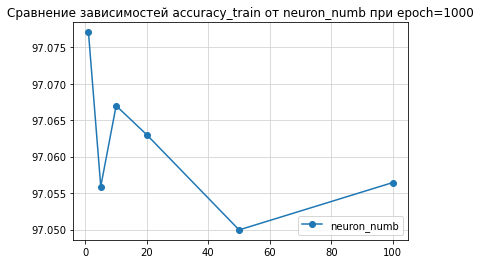

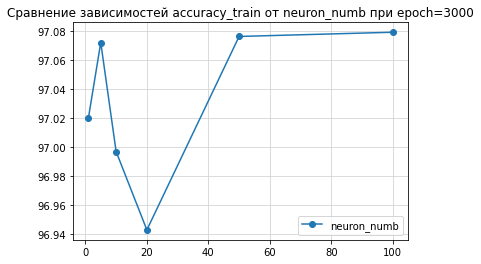

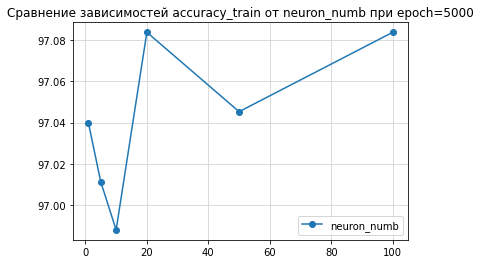

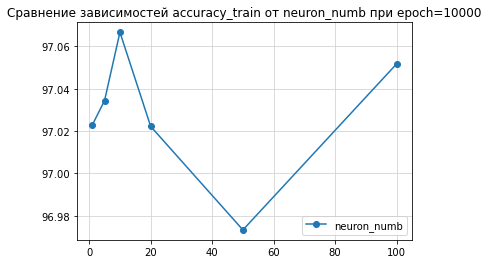

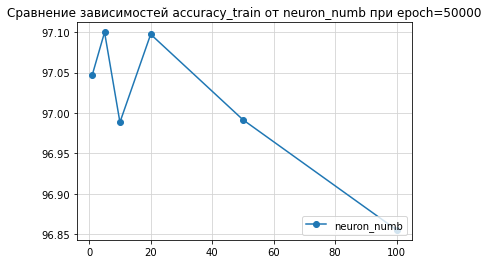

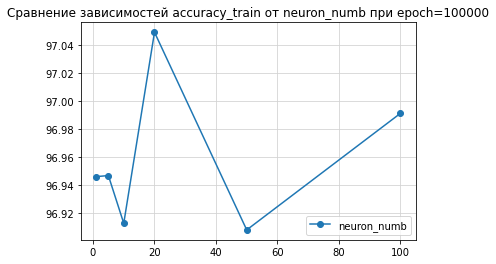

In [40]:
show_plot_res(res, iter_param='epoch', accurasy_param='accuracy_train')

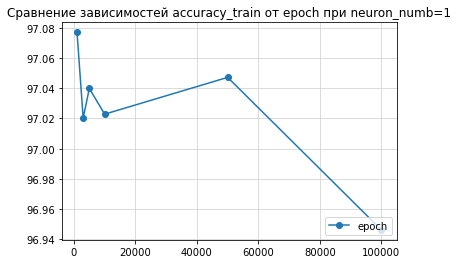

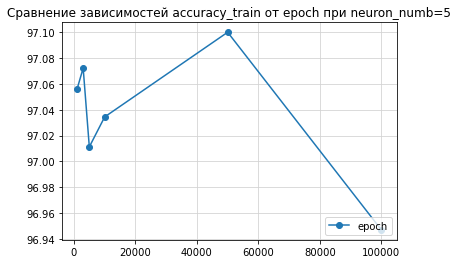

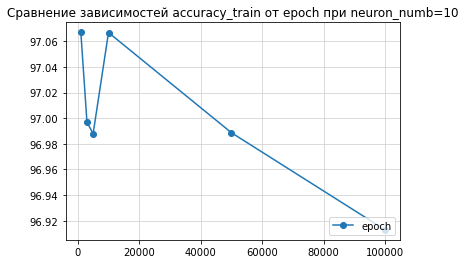

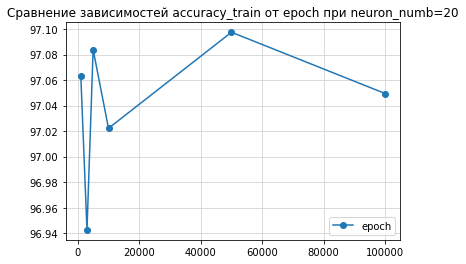

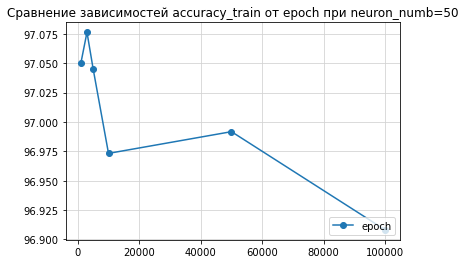

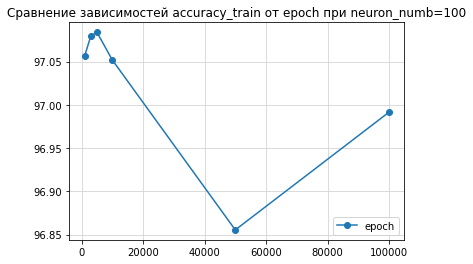

In [41]:
show_plot_res(res, iter_param='neuron_numb', accurasy_param='accuracy_train')

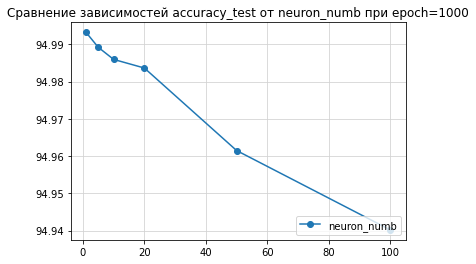

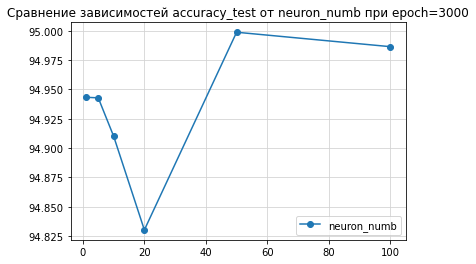

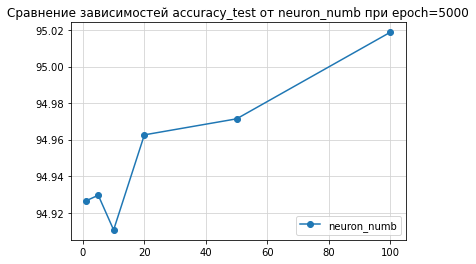

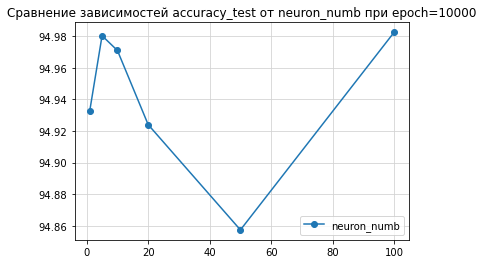

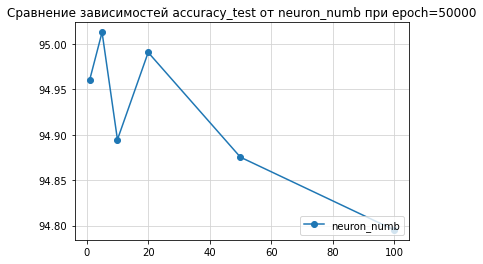

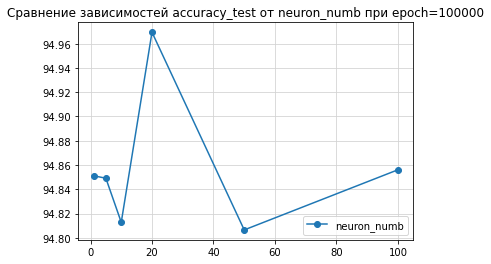

In [42]:
show_plot_res(res, iter_param='epoch', accurasy_param='accuracy_test')

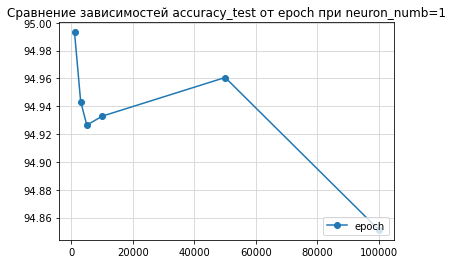

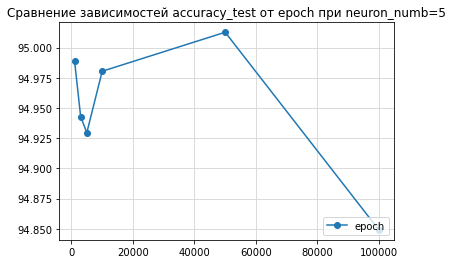

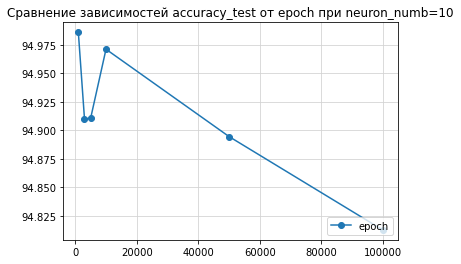

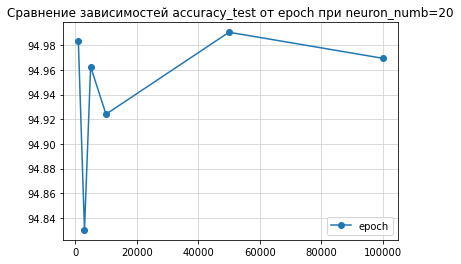

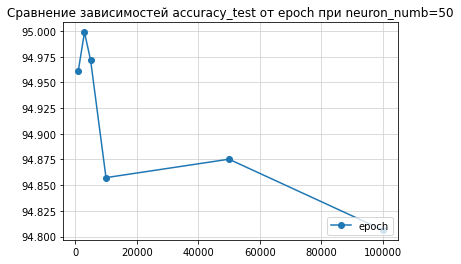

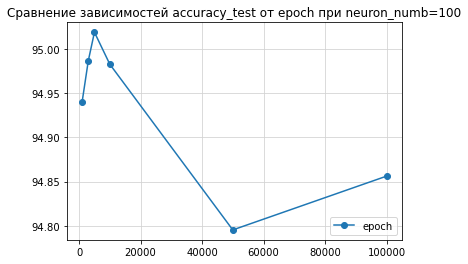

In [43]:
show_plot_res(res, iter_param='neuron_numb', accurasy_param='accuracy_test')

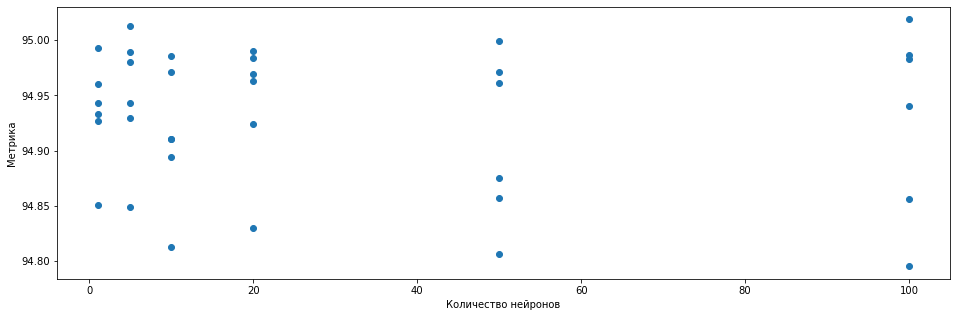

In [10]:
plt.figure(figsize = (16,5))
plt.scatter(res['neuron_numb'], res['accuracy_test'])
plt.xlabel('Количество нейронов')
plt.ylabel('Метрика')
plt.show()

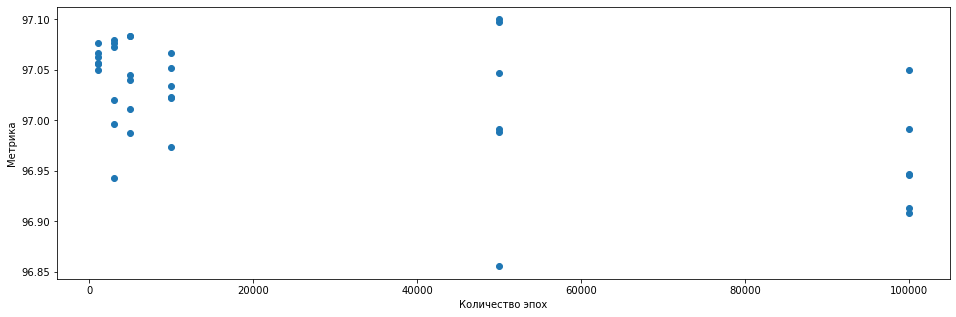

In [11]:
plt.figure(figsize = (16,5))
plt.scatter(res['epoch'], res['accuracy_train'])
plt.xlabel('Количество эпох')
plt.ylabel('Метрика')
plt.show()

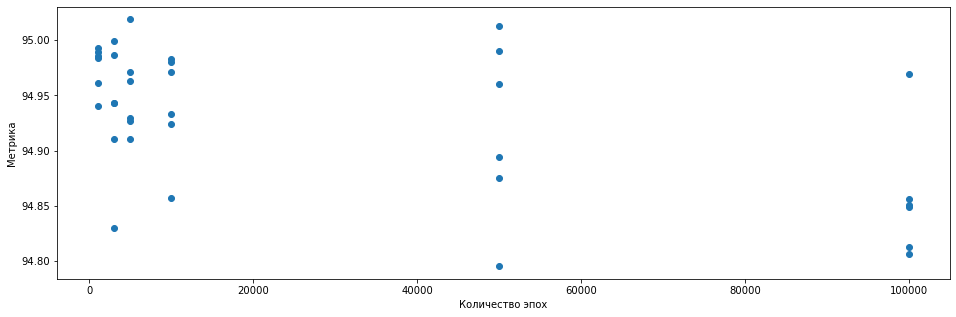

In [12]:
plt.figure(figsize = (16,5))
plt.scatter(res['epoch'], res['accuracy_test'])
plt.xlabel('Количество эпох')
plt.ylabel('Метрика')
plt.show()

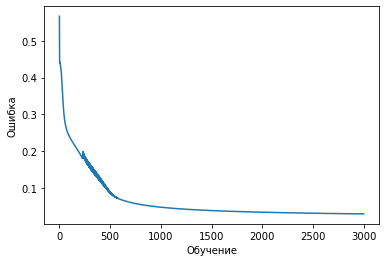

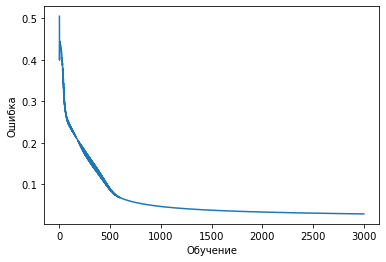

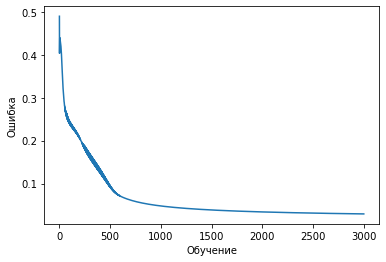

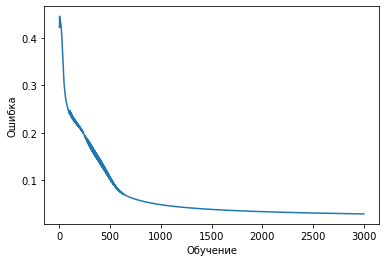

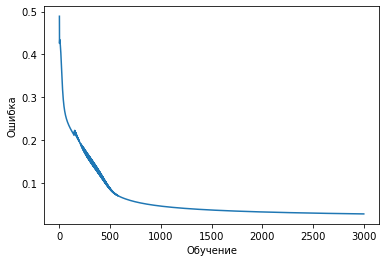

In [13]:

### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения
for error in results_sort['errors'].head():
    plt.plot(error)
    plt.xlabel('Обучение')
    plt.ylabel('Ошибка')
    plt.show() # расскоментируйте, чтобы посмотреть 

